# Oversampling and Noise Shaping

In [1]:
pkg load signal
pkg load communications 

OpenJDK 64-Bit Server VM warning: Archived non-system classes are disabled because the java.system.class.loader property is specified (value = "org.octave.OctClassLoader"). To use archived non-system classes, this property must be not be set


In [2]:
nbits = 4; % número de bits do quantizados
M = 8; % fator de oversampling
fs = M*8820; % freq. amostragem (Hz)
f0 = 440; % freq. da senoide (Hz)
t = [0 : 1/fs : 3]; % vetor de tempo
x = sin(2*pi*f0*t); % sinal senoidal
tm = 0.1; % 100ms para chegar ao max
Nm = round(tm*fs);
w = sin(t(1:Nm)*(pi/2)*(1/tm));
w = [w ones(1,length(x)-2*length(w)) w(end:-1:1)];
x = x.*w;

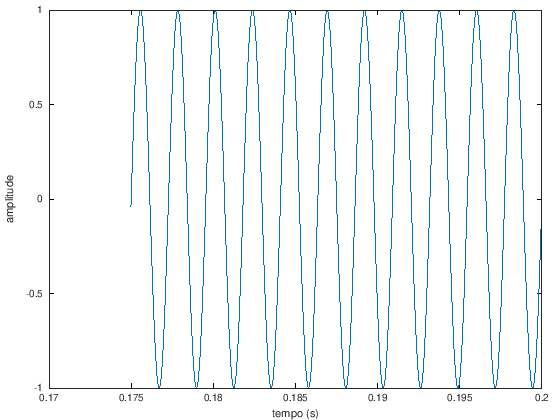

In [3]:
plot(t(1.75*Nm:2*Nm),x(1.75*Nm:2*Nm));
xlabel('tempo (s)'); ylabel('amplitude');

In [4]:
% quantizador
Xm = 1;
B = nbits-1;
delta = Xm/(2^B); 
codes = [-Xm:delta:Xm-delta];
table = (codes(1:end-1)+codes(2:end))/2; 

In [5]:
function P = snr(s,e)
  s=s(:); e=e(:);
  Ps = sum(s.^2);
  Pe = sum(e.^2);
  P = 10*log10(Ps/Pe);
endfunction

ALSA lib pcm_dmix.c:1089:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2642:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:869:(find_matching_chmap) Found no matching channel map
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA

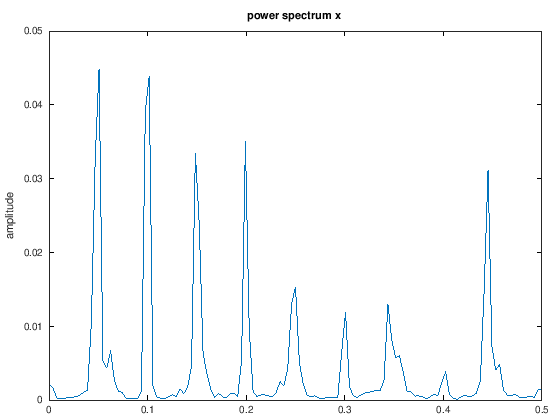

In [6]:
% sinal amostrado com freq. de amostragem fs e quantizado com nbits
xd = downsample(x,M);
[qidx, y, distor] = quantiz(xd, table, codes);
sound(y, fs/M);
e = xd - y;
pwelch(e);

In [7]:
printf("SQNR = %.1f dB", snr(xd,e));

SQNR = 23.2 dB
SQNR = 23.2 dB


SQNR = 25.5 dB
SQNR = 25.5 dB


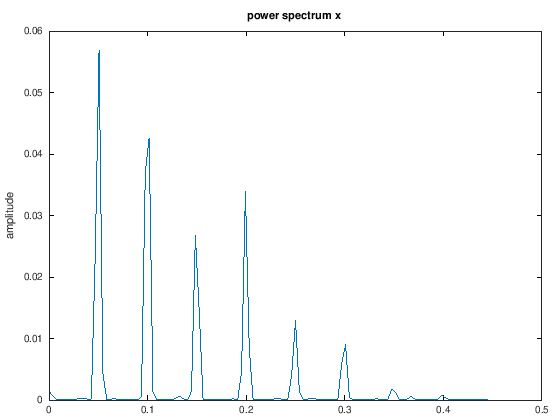

In [8]:
% sinal amostrado com oversampling de fator M e quantizado com nbits
[qidx, y, distor] = quantiz(x, table, codes);
y = decimate(y,M); 
sound(y, fs/M);
e = xd - y;
pwelch(e);
printf("SQNR = %.1f dB", snr(xd,e));

SQNR = 21.6 dB
SQNR = 21.6 dB


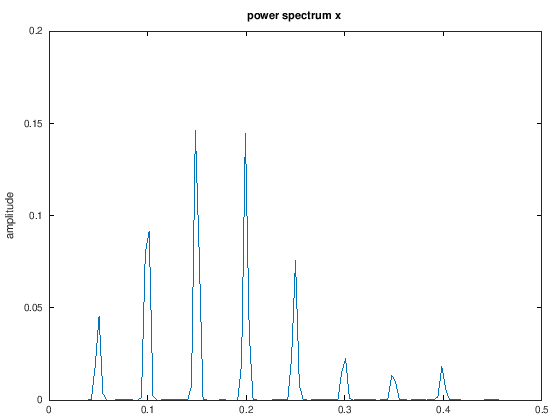

In [9]:
% oversampling e noise shaping
y = [0]; % saida do quantizador com noise shaping
v = [0];
for i = 1 : length(x),
  w(i) = x(i)-y(i); % w[i] = x[i] - y[i-1]
  v(i+1) = w(i) + v(i); % v[n] = w[n] + v[n-1]
  [qidx, vq] = quantiz(v(i+1), table, codes);
  y(i+1)=vq;
endfor;
y = y(2:end);
y = decimate(y,M);
sound(y, fs/M);
e = xd - y;
pwelch(e);
printf("SQNR = %.1f dB", snr(xd,e));